In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in E.coli - BacDrop

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/BacDrop"
data_gene = sc.read_h5ad(data_path + "/ecoli_data_processed.h5ad")


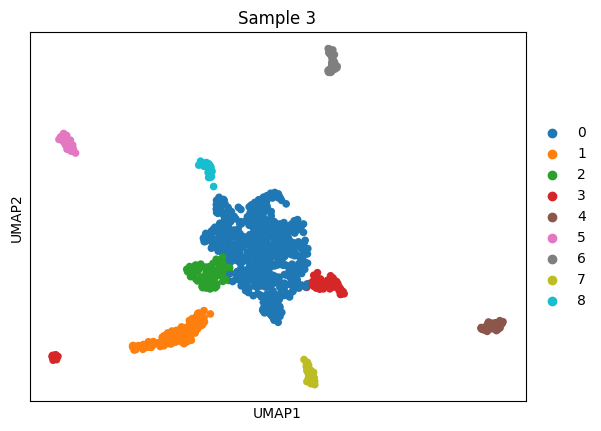

In [4]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [5]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB without starting params
gene 500
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 600
Both NB and ZINB not converged! Using NB without starting params
gene 700
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not

In [6]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-ECs_1431,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178892,...,NaN,NaN,NaN,0.003052,0.003043,0.000009,poi,0.011504,inf,0.734309
cds-ECs_2321,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119322,...,NaN,NaN,NaN,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962
cds-ECs_2323,34,0.034588,0.034003,96.541200,34.0,3.555348,34,0.033393,False,1.412980,...,NaN,NaN,NaN,0.034588,0.033392,0.001196,poi,0.034623,inf,0.001179
cds-ECs_2640,3,0.004069,0.004061,99.694812,4.0,1.609438,3,0.006087,False,0.012463,...,NaN,NaN,NaN,0.004069,0.006087,-0.002018,nb,0.004075,0.005521,0.000000
cds-ECs_2775,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178892,...,NaN,NaN,NaN,0.003052,0.003043,0.000009,poi,0.011504,inf,0.734309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_313381.1,10,0.011190,0.011128,98.982706,11.0,2.484907,10,0.013099,False,0.238025,...,NP_313381.1,transcriptional regulator,rob,0.011190,0.013100,-0.001909,nb,0.011192,0.057329,0.000000
cds-NP_313386.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119322,...,NP_313386.1,two-component regulatory system response regul...,arcA,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962
cds-YP_009502594.1,17,0.017294,0.017146,98.270600,17.0,2.890372,17,0.016995,False,0.198072,...,YP_009502594.1,cytochrome d (bd-I) ubiquinol oxidase subunit X,cydX,0.017294,0.016995,0.000299,poi,0.017314,inf,0.001407
cds-YP_009502638.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119322,...,YP_009502638.1,hypothetical protein,yecJ,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962


## Find optimal correlation matrix scaling and generate synthetic null data

In [7]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 13.156602771853072
Factor: 2 - Error: 12.95238375057245
Factor: 3.6180339999999998 - Error: 12.965378573141754
Factor: 2 - Error: 12.95238375057245
Factor: 2.61803399102434 - Error: 12.667321531559748
Factor: 3.000000004452737 - Error: 12.397454604301306
Factor: 3.2360679837762825 - Error: 13.217678943313965
Factor: 2.8541019703478856 - Error: 13.008200734144262
Factor: 3.090169948603714 - Error: 12.656096625992747
Factor: 2.944271914498863 - Error: 13.086838882484836
Factor: 3.0344418582420083 - Error: 12.487976417536066
Factor: 2.9787137682881344 - Error: 12.927326073009453
Factor: 3.0131556219216282 - Error: 12.680012955346927
Factor: 2.9918693857570258 - Error: 12.723391454630745
Factor: 3.0050250031664154 - Error: 12.932266208937312
Factor: 2.9968943844707043 - Error: 12.773385699056684
Factor: 3.0019193831616557 - Error: 12.454905585900812
Factor: 2.9988137631796237 - Error: 12.681509149953538
Factor: 3.0007331418798615 - Error: 12.177635026586433
Factor: 3.001

In [8]:
importlib.reload(cd)
xmin=1

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [9]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [10]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [11]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

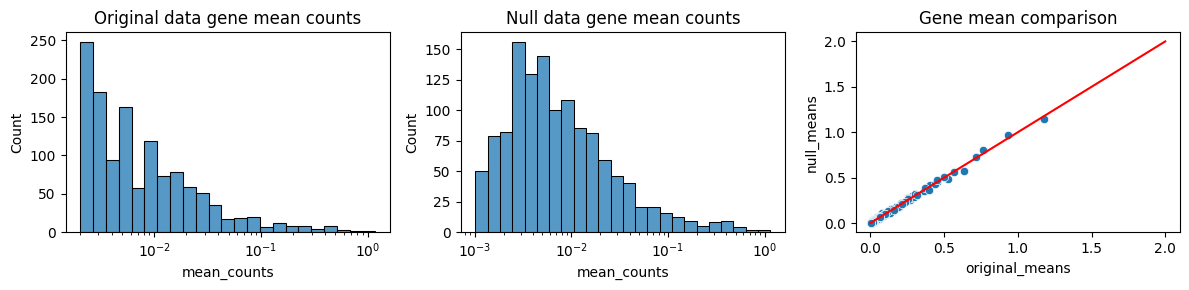

SignificanceResult(statistic=0.9386368675072818, pvalue=0.0)


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

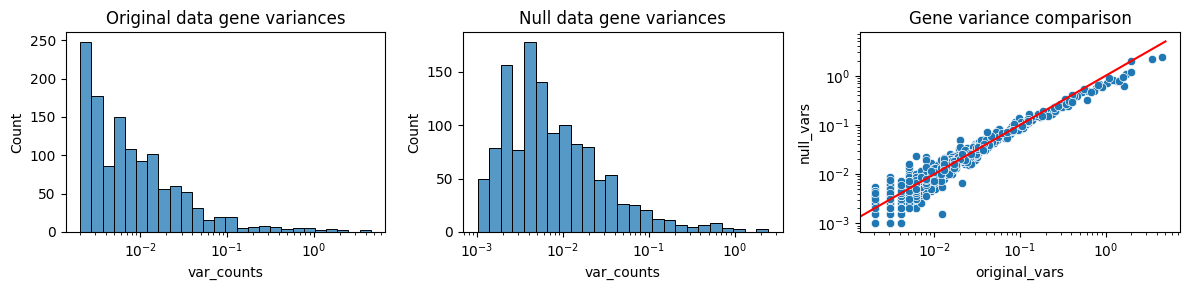

SignificanceResult(statistic=0.9297799419999535, pvalue=0.0)
[[1.         0.97437307]
 [0.97437307 1.        ]]


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

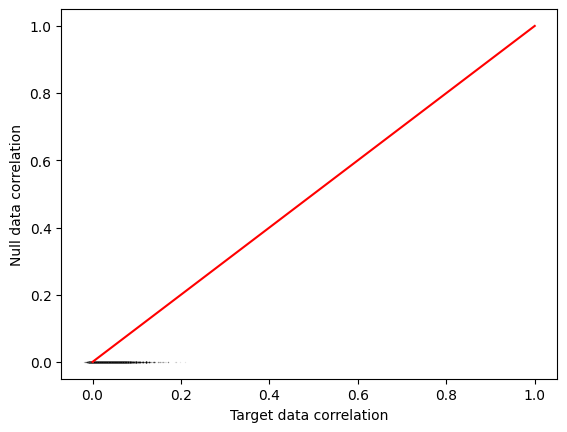

In [14]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [15]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [16]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


25


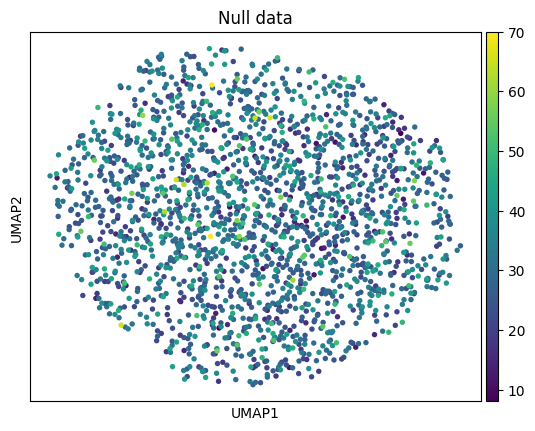

In [17]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [18]:
data_null_gen.write(data_path + "/null_data_ecoli.h5ad")

In [19]:
n_splits = 1
rng = np.random.default_rng(1234)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    was_greater = False
    max_res_1_cluster = 0.01
    
    while twoclust is False:
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        print(f"resolution: {res2}, clusters: {nclust}")

        if nclust == 2:
            twoclust = True
            break
        elif nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 5*res_step
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 15)

            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 5*res_step
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

resolution: 0.01, clusters: 1
resolution: 0.035, clusters: 1
resolution: 0.06, clusters: 1
resolution: 0.085, clusters: 1
resolution: 0.11, clusters: 1
resolution: 0.135, clusters: 1
resolution: 0.16, clusters: 1
resolution: 0.185, clusters: 1
resolution: 0.21, clusters: 1
resolution: 0.235, clusters: 1
resolution: 0.26, clusters: 1
resolution: 0.285, clusters: 1
resolution: 0.31, clusters: 1
resolution: 0.335, clusters: 2
split 1/1 - Resolution 0.335
Best split: No. 0 - seed: 979 - minimal p-value: 2.343695431810287e-06


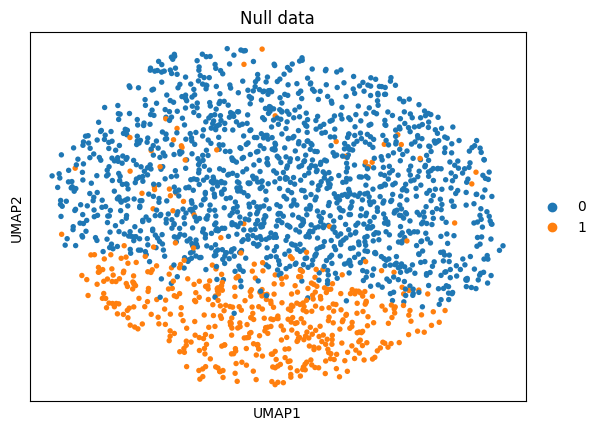

In [20]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [21]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_ecoli.h5ad")

In [22]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.25862068965517243
Cluster 7 - DE genes: 37; Minimum q value: 0.02702702702702703
Cluster 3 - DE genes: 43; Minimum q value: 0.04
Cluster 2 - DE genes: 33; Minimum q value: 0.030303030303030304
Cluster 6 - DE genes: 52; Minimum q value: 0.02127659574468085
Cluster 8 - DE genes: 43; Minimum q value: 0.043478260869565216
Cluster 5 - DE genes: 56; Minimum q value: 0.018518518518518517
Cluster 4 - DE genes: 39; Minimum q value: 0.02564102564102564
Cluster 1 - DE genes: 0; Minimum q value: 0.0625


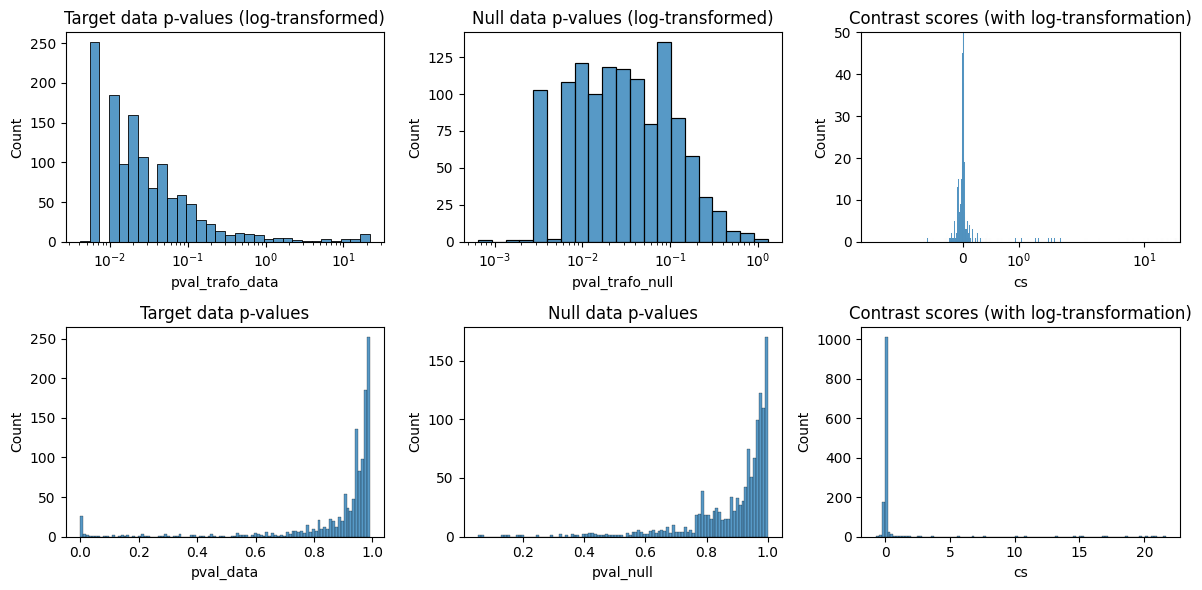

In [23]:
c = "4"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [24]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
0.258621     58
0.261538      7
0.283784      9
0.298701      3
0.301205      6
           ... 
0.568855      4
0.580977      1
0.582586      3
0.583439      4
1.000000    484
Name: q, Length: 75, dtype: int64

cluster 7
0.027027     37
0.100000      3
0.121951      1
0.145833      7
0.163265      1
0.188679      4
0.232143      3
0.344828      2
0.389831      1
0.516667      1
0.523810      3
0.525641     15
0.587500      2
0.592593      1
0.666667      3
0.670588      1
0.712644      2
0.719101      2
0.744444      1
0.771739      2
0.840426      2
0.857143      4
0.864157    513
0.864379      1
1.000000    657
Name: q, dtype: int64

cluster 3
0.040000     25
0.046512     18
0.055556     11
0.060606     12
0.071429      4
0.097222      2
0.109589      1
0.120000      2
0.128205      3
0.139241      1
0.162500      1
0.182927      2
0.190476      2
0.220930      2
0.229885      1
0.233333      3
0.292929      9
0.306931      2
0.309735     12
0.353846     17
0.358779      1


In [25]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
cds-NP_312199.1,3.273449e-11,0.873798,10.484994,0.058589,10.426405,0.258621
cds-NP_312936.1,7.168570e-08,0.252866,7.144567,0.597109,6.547458,0.258621
cds-NP_309021.1,1.547165e-05,0.436434,4.810463,0.360082,4.450382,0.258621
cds-NP_312206.1,1.558474e-05,0.306947,4.807300,0.512936,4.294364,0.258621
cds-NP_312513.1,1.735564e-04,0.539975,3.760559,0.267627,3.492933,0.258621
...,...,...,...,...,...,...
cds-NP_309013.1,6.519672e-01,0.017908,0.185774,1.746948,-1.561174,1.000000
cds-NP_312188.1,2.368069e-02,0.000359,1.625606,3.444933,-1.819327,1.000000
cds-NP_313151.1,3.781612e-01,0.000911,0.422323,3.040250,-2.617927,1.000000
cds-NP_309770.2,2.056557e-02,0.000017,1.686859,4.758415,-3.071556,1.000000


In [26]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [27]:
data_gene_nonzero.write(data_path + "/ecoli_data_processed_cluster.h5ad")

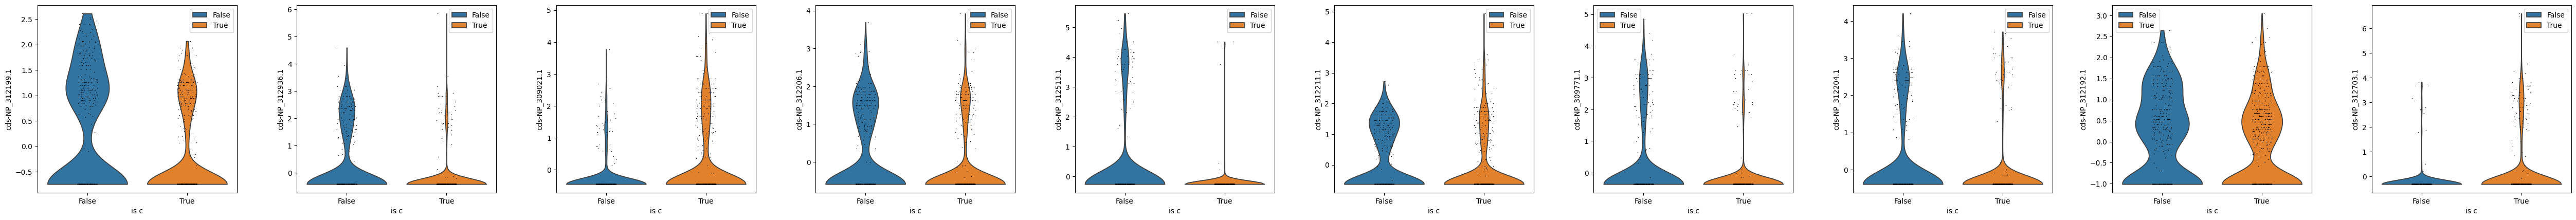

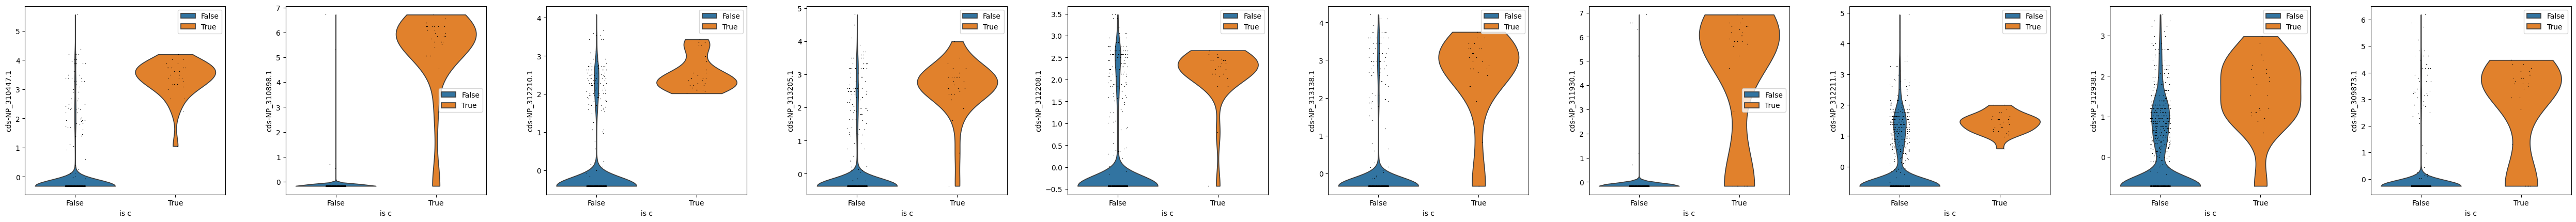

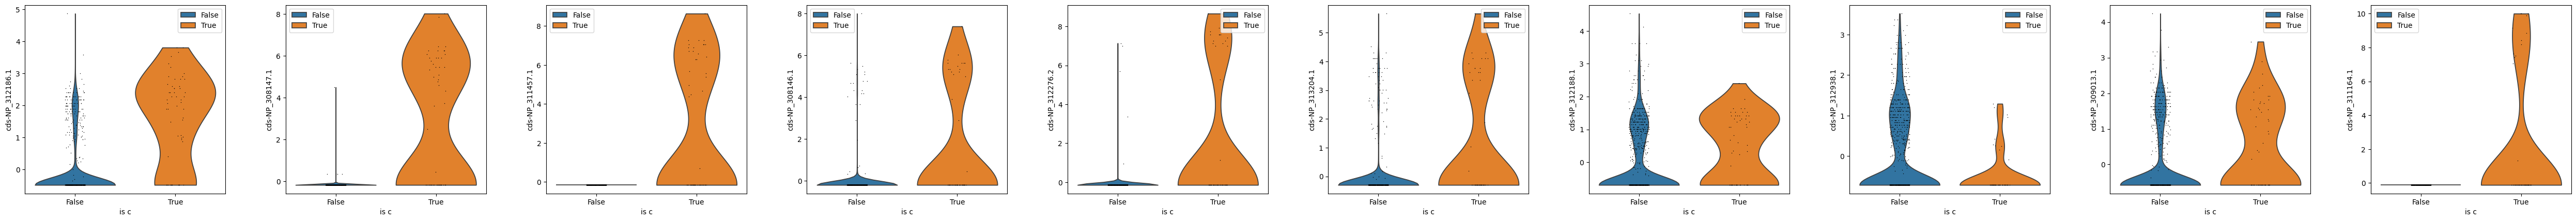

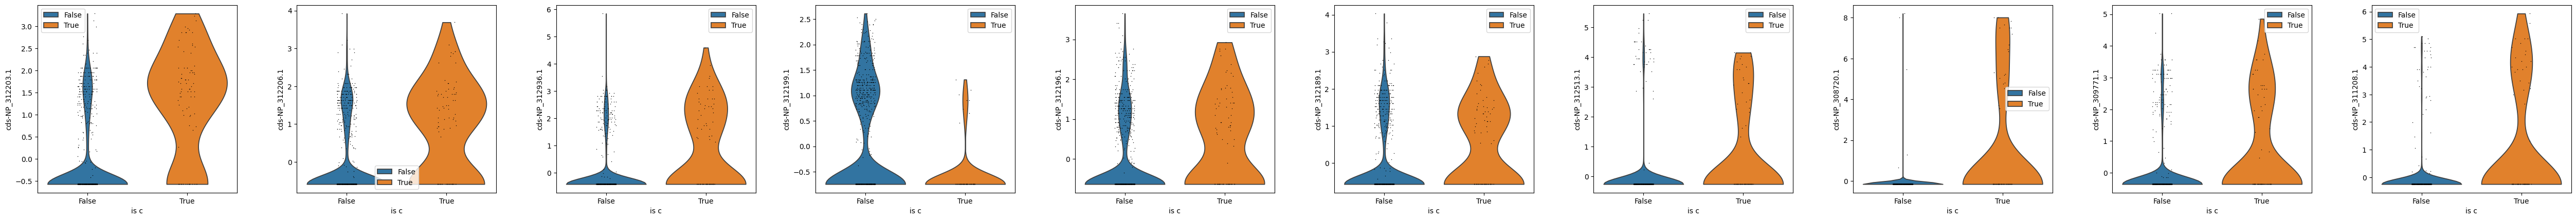

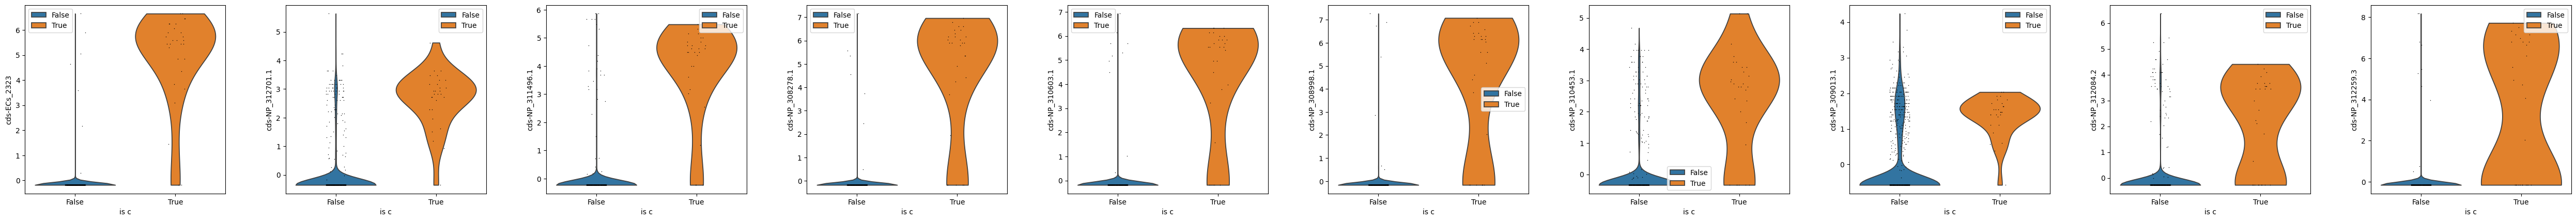

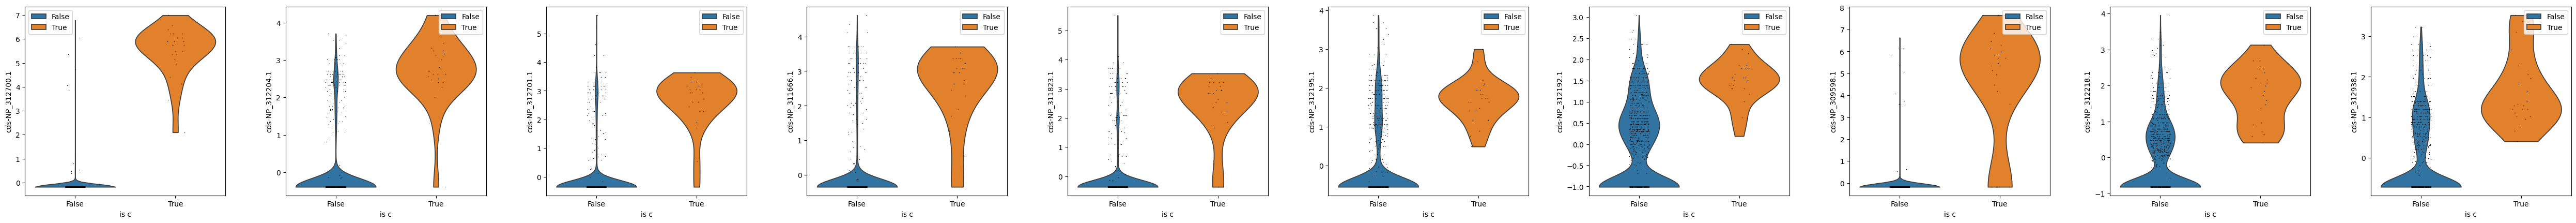

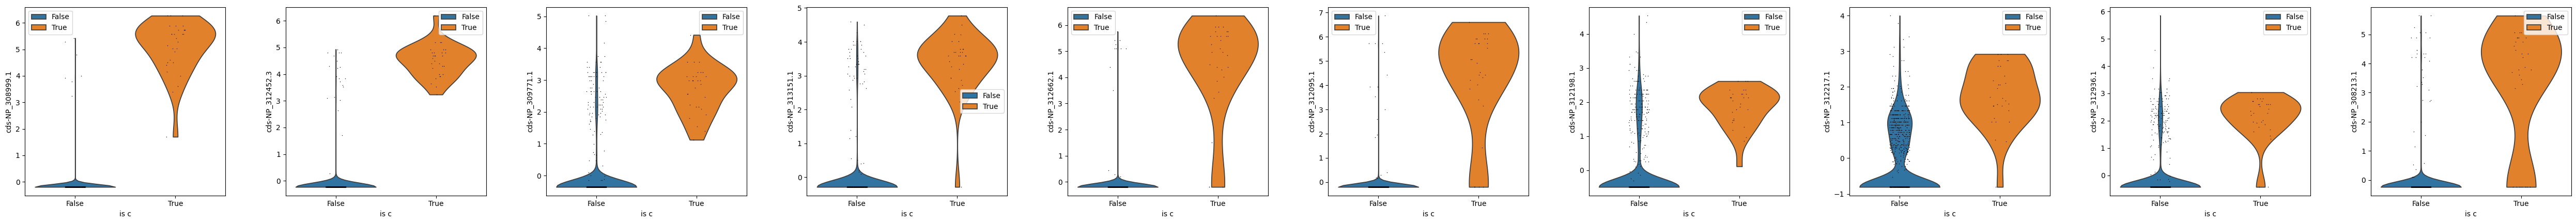

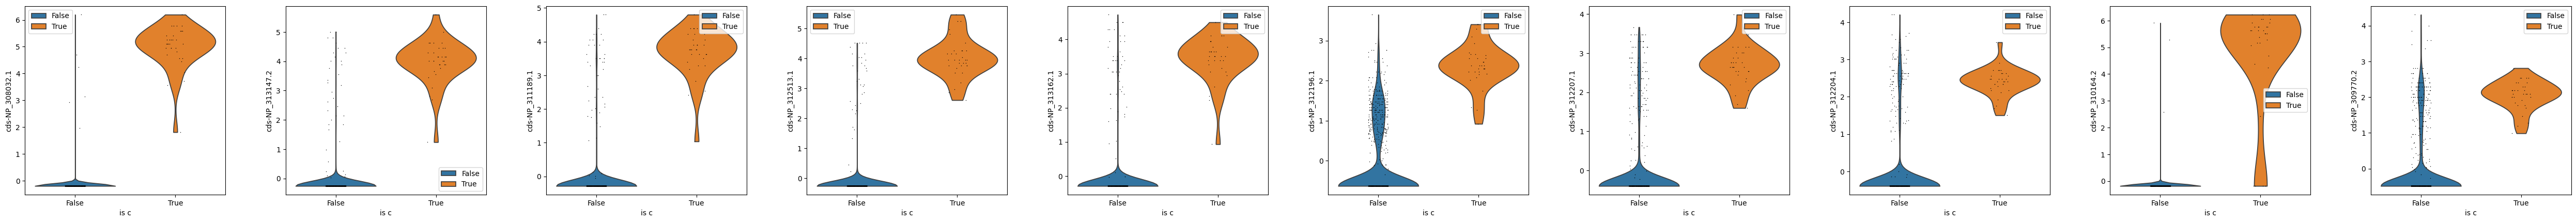

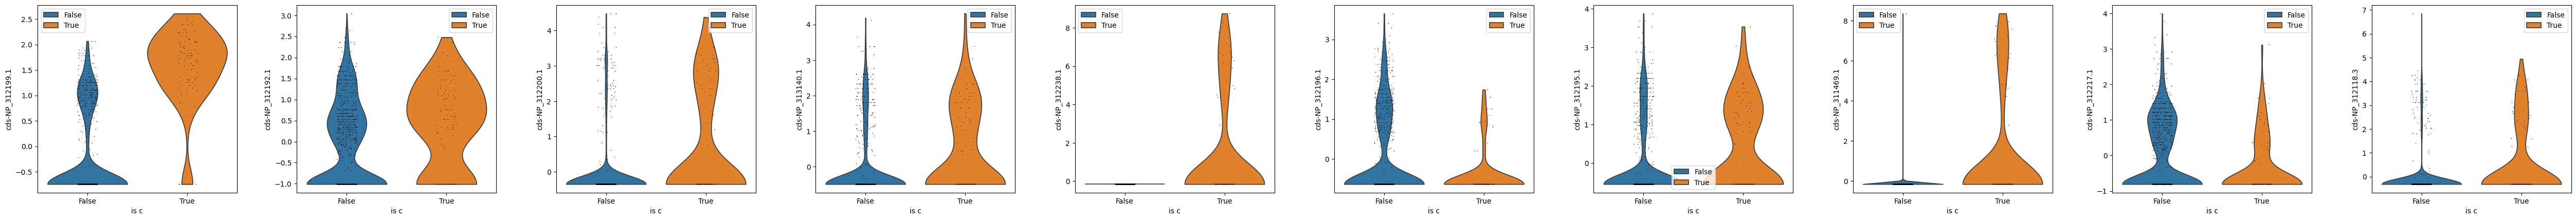

In [28]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [29]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-ECs_1431,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178892,...,NaN,NaN,NaN,0.003052,0.003043,0.000009,poi,0.011504,inf,0.734309
cds-ECs_2321,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119322,...,NaN,NaN,NaN,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962
cds-ECs_2323,34,0.034588,0.034003,96.541200,34.0,3.555348,34,0.033393,False,1.412980,...,NaN,NaN,NaN,0.034588,0.033392,0.001196,poi,0.034623,inf,0.001179
cds-ECs_2640,3,0.004069,0.004061,99.694812,4.0,1.609438,3,0.006087,False,0.012463,...,NaN,NaN,NaN,0.004069,0.006087,-0.002018,nb,0.004075,0.005521,0.000000
cds-ECs_2775,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178892,...,NaN,NaN,NaN,0.003052,0.003043,0.000009,poi,0.011504,inf,0.734309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_313381.1,10,0.011190,0.011128,98.982706,11.0,2.484907,10,0.013099,False,0.238025,...,NP_313381.1,transcriptional regulator,rob,0.011190,0.013100,-0.001909,nb,0.011192,0.057329,0.000000
cds-NP_313386.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119322,...,NP_313386.1,two-component regulatory system response regul...,arcA,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962
cds-YP_009502594.1,17,0.017294,0.017146,98.270600,17.0,2.890372,17,0.016995,False,0.198072,...,YP_009502594.1,cytochrome d (bd-I) ubiquinol oxidase subunit X,cydX,0.017294,0.016995,0.000299,poi,0.017314,inf,0.001407
cds-YP_009502638.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119322,...,YP_009502638.1,hypothetical protein,yecJ,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962


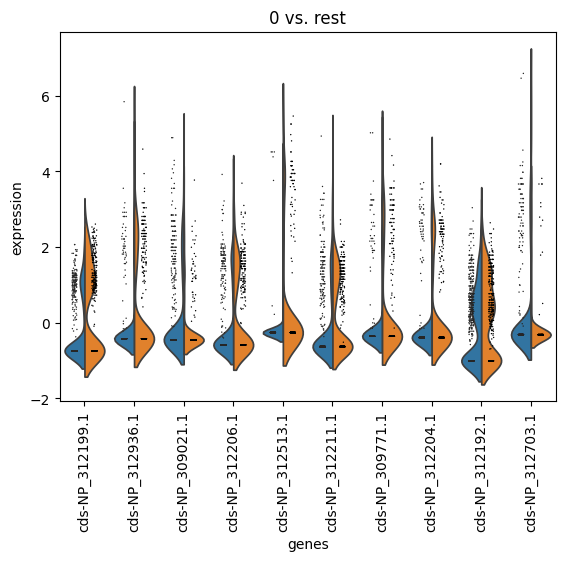

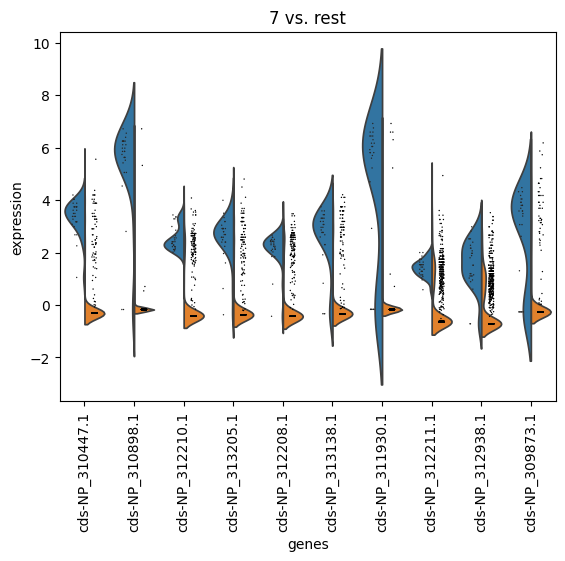

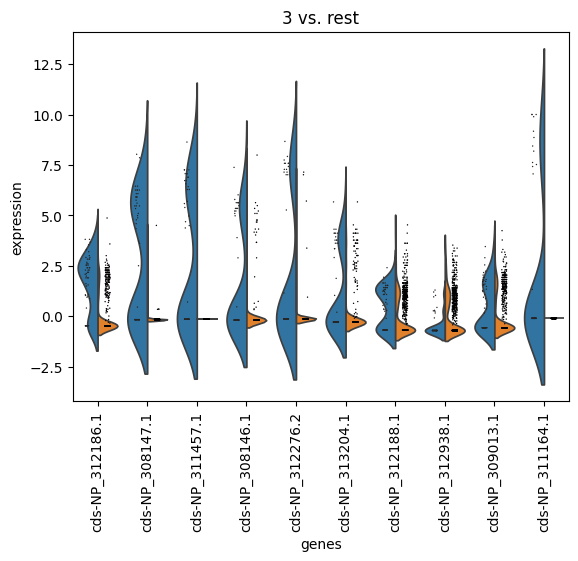

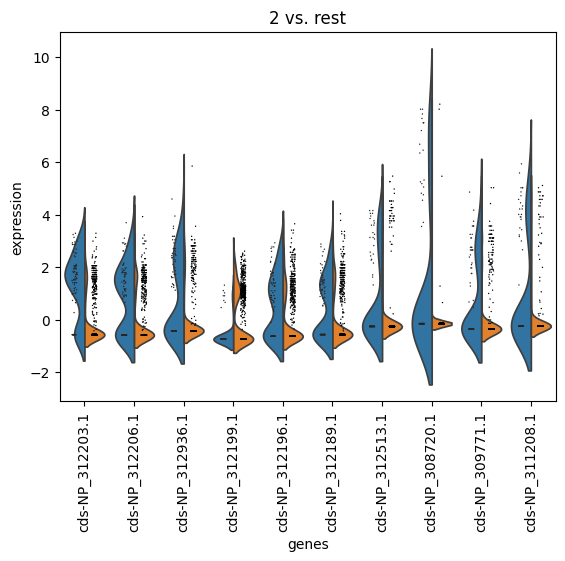

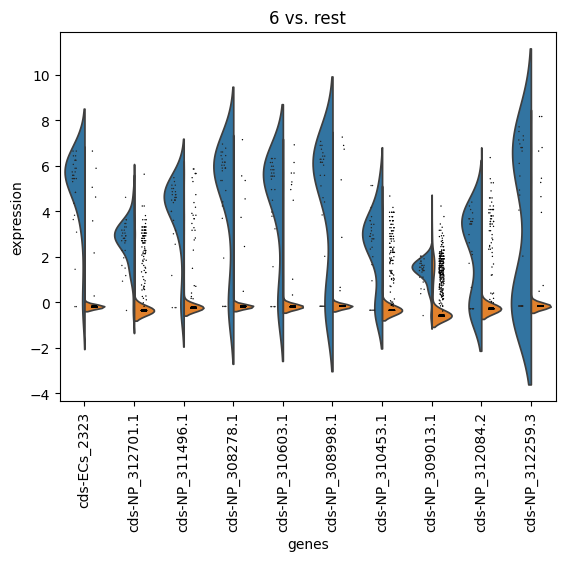

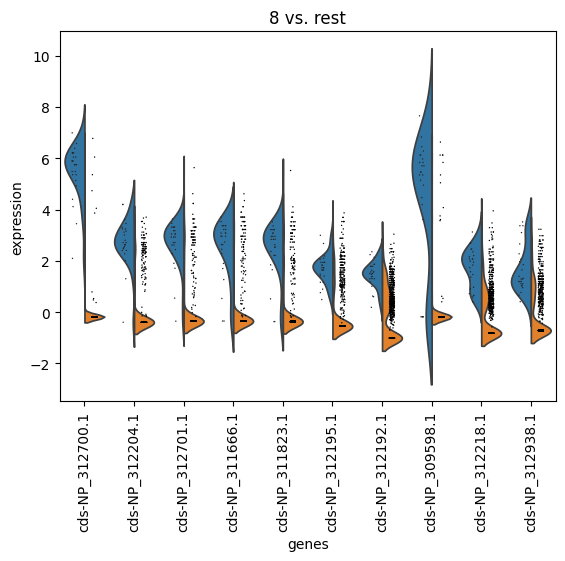

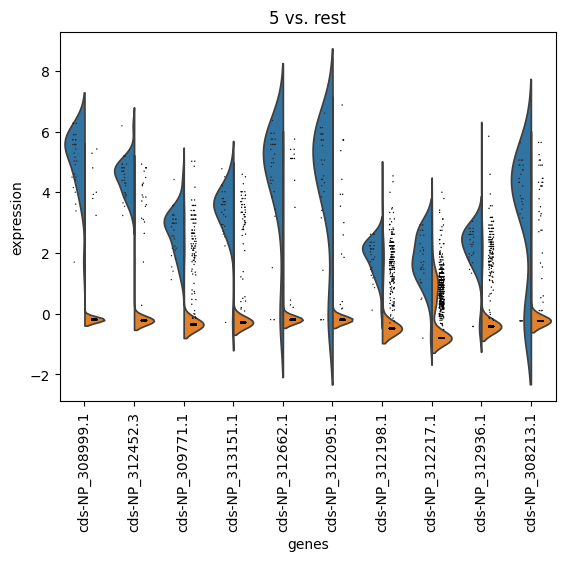

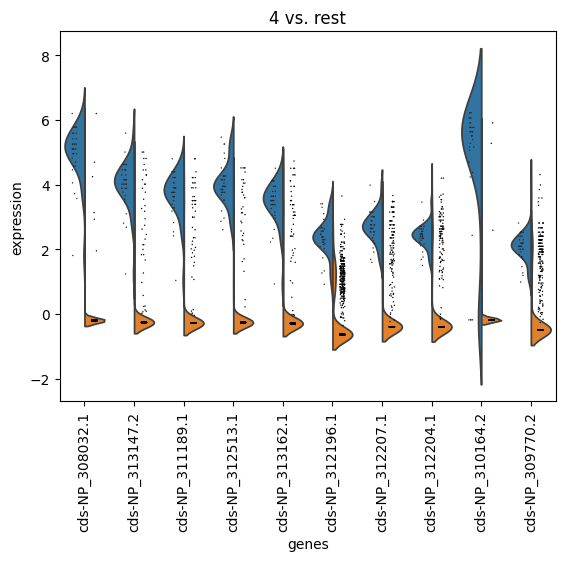

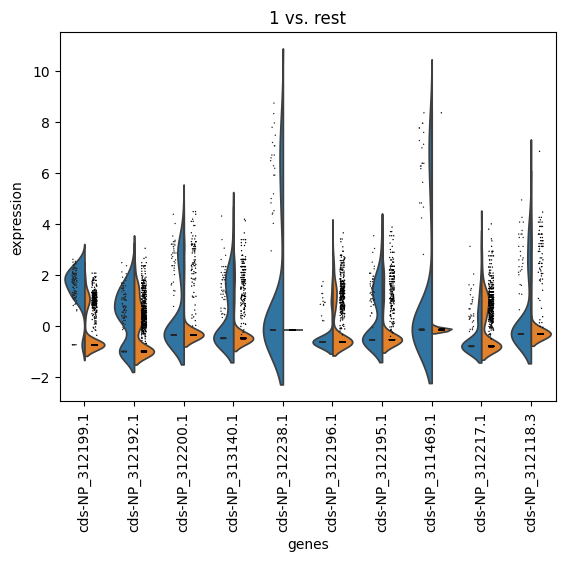

In [30]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [31]:
p_cutoff = 0.05
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].loc[data_gene_nonzero.uns["ClusterDE_results"][c]["q"] < p_cutoff,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["locus_tag", "name", "symbol"]])

Cluster 0
Empty DataFrame
Columns: [locus_tag, name, symbol]
Index: []
Cluster 7
                locus_tag                                          name  \
cds-NP_310447.1  ECs_2420    phenylalanine tRNA synthetase beta subunit   
cds-NP_310898.1  ECs_2871          outer membrane assembly protein AsmA   
cds-NP_312210.1  ECs_4183             50S ribosomal subunit protein L23   
cds-NP_313205.1  ECs_5178             30S ribosomal subunit protein S18   
cds-NP_312208.1  ECs_4181             30S ribosomal subunit protein S19   
cds-NP_313138.1  ECs_5111                        lysine tRNA synthetase   
cds-NP_311930.1  ECs_3903                DNA topoisomerase IV subunit A   
cds-NP_312211.1  ECs_4184              50S ribosomal subunit protein L4   
cds-NP_312938.1  ECs_4911             RNA polymerase beta prime subunit   
cds-NP_309873.1  ECs_1846                           DNA topoisomerase I   
cds-NP_312930.1  ECs_4903         translation elongation factor EF-Tu 1   
cds-NP_311684.1  EC

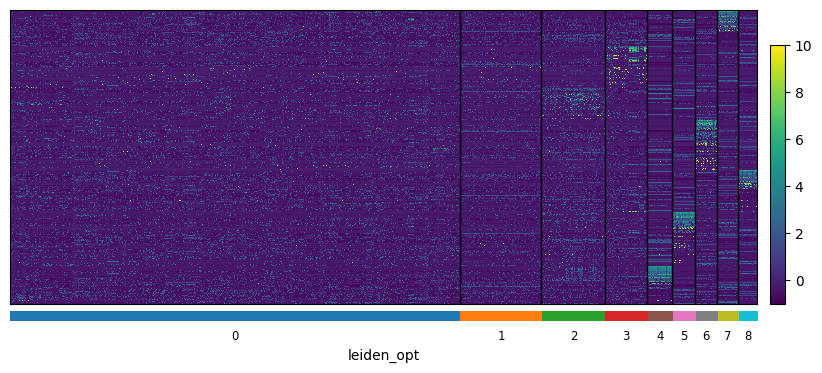

In [32]:
with plt.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True)